# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Load the Data


In [3]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive/Residency10/LAB/External")

In [7]:
npz = np.load('/content/drive/My Drive/Residency10/LAB/External/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

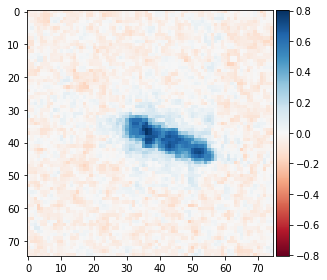

This is: Ship


In [36]:
ix = 100 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']#0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

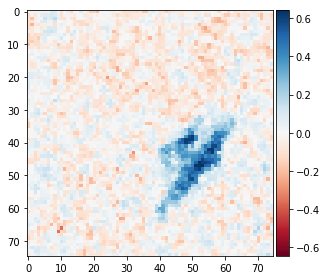

This is: Iceberg


In [37]:
ix = 200 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']#0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

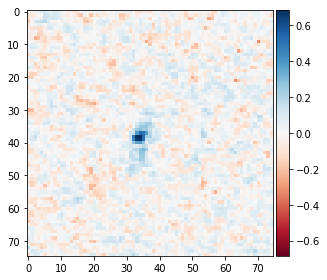

This is: Iceberg


In [38]:
ix = 400 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']#0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

In [0]:
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [42]:
left_input = Input((75,75,3))
right_input = Input((75,75,3))

# We will use 2 instances of 1 network for this task
baseNetwork = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.


# Process the left and right inputs to the same Base Network(base_network)

In [0]:
encoded_l = baseNetwork(left_input)
encoded_r = baseNetwork(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))


In [0]:
L1_distance = L1_layer([encoded_l, encoded_r])


# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
prediction = Dense(1,activation='sigmoid')(L1_distance)


# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
optimizer = Adam(0.001, decay=2.5e-4)


# Show the Summary of your Siamese Network

In [0]:
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)


In [0]:
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])


In [50]:
siamese_net.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18)           0           sequential_1[1][0]               
          

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [52]:
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 3113 samples
Epoch 1/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.6871 - acc: 0.5476 - val_loss: 0.7234 - val_acc: 0.3800
Epoch 2/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.6237 - acc: 0.6578 - val_loss: 0.7450 - val_acc: 0.5088
Epoch 3/30
5000/5000 [==============================] - 56s 11ms/step - loss: 0.5315 - acc: 0.7506 - val_loss: 0.5451 - val_acc: 0.7568
Epoch 4/30
5000/5000 [==============================] - 53s 11ms/step - loss: 0.4756 - acc: 0.7830 - val_loss: 0.5686 - val_acc: 0.7186
Epoch 5/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4353 - acc: 0.8090 - val_loss: 0.6836 - val_acc: 0.6010
Epoch 6/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4073 - acc: 0.8312 - val_loss: 0.5380 - val_acc: 0.7661
Epoch 7/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.3882 - a